# SimGrid MPI calibration of a Grid5000 cluster

Copied from: https://github.com/Ezibenroc/calibration_analysis/blob/master/dahu/mpi/remote_calibration_adhoc.ipynb

packages
python
- pip install plotnine
- pip install pycewise

R
- install.packages("mclust")
- install.packages("Ckmeans.1d.dp")
- install.packages("quantreg")

## Utility classes and functions

### R

In [1]:
import rpy2
%load_ext rpy2.ipython
%R library(Ckmeans.1d.dp)
%R set.seed(42) #forcing seed for reproductibility

### Python

In [2]:
import os
import zipfile
import yaml
import pandas
import io
import numpy
from math import sqrt
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from pycewise import *

In [3]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

def find_clusters(arr, bw, min_size=10):
    '''
    Find the clusters in the given 1D data.
    Links:
        - https://stackoverflow.com/q/11513484/4110059
        - https://stackoverflow.com/q/35094454/4110059
    We assume here that the clusters are exponentially spread (i.e. the data needs to be looked in log-scale).
    The parameter bw controls the "smoothness" of the used density estimation. A smaller bw will give more clusters.
    The parameter min_size defines the minimum size of the clusters (if smaller ones are found, they will be merged).
    '''
    # First, we shift all the input values by a constant since we cannot have negative values
    arr = array(arr)
    shift = -arr.min() + arr.mean()
    arr += shift
    # Then we switch to log scale.
    arr = numpy.log10(arr.reshape(-1, 1))
    # We compute the density of this data.
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(arr)
    s = linspace(min(arr), max(arr), num=100)
    e = kde.score_samples(s.reshape(-1,1))
    # We search for the local minima of the density.
    mi, ma = argrelextrema(e, numpy.less)[0], argrelextrema(e, numpy.greater)[0]
    # We remove the clusters that contain less than min_size values
    mi = [float('-inf')] + list(s[mi]) + [float('+inf')]
    bounds = []
    for left, right in zip(mi[:-1], mi[1:]):
        print(left, right)
        if len(arr[(arr > left) & (arr < right)]) >= min_size:
            bounds.append(left)
    return 10**array(bounds[1:])-shift

In [4]:
class Util:
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other
    def __truediv__(self, other):
        return self * (1/other)
    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return '%s(...)' % self.__class__.__name__

class Normal(Util):
    '''
    Represent a variable following a normal distribution N(μ, σ²)
    '''
    def __init__(self, mu, sigma):
        self.mu = mu
        assert sigma >= 0
        self.sigma = sigma
        self.half = False

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            if self.sigma == 0:
                return str(self.mu)
            return 'N(%s, %s)' % (self.mu, self.sigma)

    def to_tex(self):
        if self.sigma == 0:
            return self.number_to_tex(self.mu, digits=4)
        return r'\mathcal{N}\left(%s, %s\right)' % (self.number_to_tex(self.mu, digits=4), self.number_to_tex(self.sigma, digits=4))

    def __add__(self, other):
        '''
        https://fr.wikipedia.org/wiki/Loi_normale#Stabilit%C3%A9s_et_famille_normale
        '''
        try:
            mu = self.mu + other.mu
            sigma = sqrt(self.sigma**2 + other.sigma**2)
        except AttributeError:
            mu = self.mu + other
            sigma = self.sigma
        return Normal(mu, sigma)

    def __mul__(self, other):
        return Normal(self.mu*other, self.sigma*sqrt(abs(other)))

    def __neg__(self):
        return Normal(-self.mu, self.sigma)
    
    def sample(self):
        if self.half:
            sigma = self.sigma/sqrt(1-2/numpy.pi)
            mu = self.mu - sigma*sqrt(2/numpy.pi)
            return mu + abs(numpy.random.normal(0, sigma))
        else:
            return numpy.random.normal(self.mu, self.sigma)

    @staticmethod
    def number_to_tex(x, digits=None):
        string = '%e' if digits is None else '%.{}e'.format(digits)
        string = string % x
        exp_i = string.index('e')
        coefficient = string[:exp_i]
        exponent = int(string[exp_i+1:])
        return r'%s\mathrm{e}{%d}' % (coefficient, exponent)

    def to_c(self, variable_name):
        if self.sigma > 0:
            return '%s = random_halfnormal_shifted(%e, %e);' % (variable_name, self.mu, self.sigma)
        else:
            return '%s = %e;' % (variable_name, self.mu)
    
dist = Normal(12, 5)
x = [dist.sample() for _ in range(1000)]
assert min(x) < -2
print(min(x), numpy.mean(x), numpy.std(x))
dist.half = True
x = [dist.sample() for _ in range(1000)]
assert min(x) > 5
print(min(x), numpy.mean(x), numpy.std(x))
print(Normal(1, 2) - Normal(3, 4))
print([Normal(1, 2).sample() for _ in range(5)])
x = Normal(3, 3)
print(x+x)
print(x*2)

class LinearRegression(Util):
    '''
    Represent a linear relation of the form y ~ αx + β
    Note that both α and β can be of any type, including random variables.
    '''
    def __init__(self, intercept, coefficient):
        if isinstance(intercept, (int, float)):
            intercept = Normal(intercept, 0)
        if isinstance(coefficient, (int, float)):
            coefficient = Normal(coefficient, 0)
        self.intercept = intercept
        self.coefficient = coefficient

    def __repr__(self):
        try:
            from IPython.display import display, Math
            display(Math(self.to_tex()))
            return ''
        except ModuleNotFoundError:
            return 'Y ~ %sX + %s' % (self.coefficient, self.intercept)

    def to_tex(self):
        result =  r'Y \sim \alpha X + \beta\\'
        result += r'\alpha \sim %s\\' % self.coefficient.to_tex()
        result += r'\beta \sim %s\\' % self.intercept.to_tex()
        return result.replace(r'\\', '\\\\\n')

    def __add__(self, other):
        try:
            intercept = self.intercept + other.intercept
            coefficient = self.coefficient + other.coefficient
        except AttributeError:  # adding a constant
            intercept = self.intercept + other
            coefficient = self.coefficient
        return LinearRegression(intercept, coefficient)

    def __mul__(self, other):
        return LinearRegression(self.intercept*other, self.coefficient*other)

    def __neg__(self):
        return LinearRegression(-self.intercept, -self.coefficient)

    def sample(self, x, half=False):
        return self.coefficient.sample() * x + self.intercept.sample()

    def to_c(self, intercept_name, coefficient_name):
        return '\n'.join(variable.to_c(name) for name, variable in [(intercept_name, self.intercept), (coefficient_name, self.coefficient)])

print(LinearRegression(Normal(1, 1), 5) + 3*LinearRegression(Normal(1, 2), Normal(3, 4)))
print([LinearRegression(Normal(1, 0.5), 5).sample(i) for i in range(5)])
print(LinearRegression(Normal(1, 0.5), 5).to_c('intercept_smpi', 'coefficient_smpi'))

-3.4803062331429597 12.470860078478688 5.028984571976822
5.387796061405608 12.094429983233978 5.138272178780271


<IPython.core.display.Math object>


[0.742036751927173, 5.787349420370267, 0.24193195612096052, 2.117607318844562, -1.4372442033894806]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


[-0.2496123578259717, 6.350043851345801, 11.092014754873825, 15.641281992805862, 20.763714671952286]
intercept_smpi = random_halfnormal_shifted(1.000000e+00, 5.000000e-01);
coefficient_smpi = 5.000000e+00;


In [5]:
class SegmentedRegression(Util):
    def __init__(self):
        self.segments = []

    def append(self, regression, min_x, max_x):
        assert len(self.segments) == 0 or min_x == self.segments[-1][2]
        self.segments.append((regression, min_x, max_x))

    def to_tex(self):
        result = []
        for reg, min_x, max_x in self.segments:
            interval_string = ''
            if min_x is not None:
                interval_string += r'%s \leq ' % min_x
            interval_string += 'X'
            if max_x is not None:
                interval_string += r' < %s' % max_x
            result.append('%s\\\\\n%s' % (interval_string, reg.to_tex()))
        return '\\\\\n'.join(result)

    def __add__(self, other):
        result = self.__class__()
        if isinstance(other, self.__class__):
            for (dist1, min_x1, max_x1), (dist2, min_x2, max_x2) in zip(self.segments, other.segments):
                assert min_x1 == min_x2 and max_x1 == max_x2
                result.append(dist1 + dist2, min_x1, max_x1)
        else:
            for distribution, min_x, max_x in self.segments:
                result.append(distribution + other, min_x, max_x)
        return result

    def __mul__(self, other):
        result = self.__class__()
        for distribution, min_x, max_x in self.segments:
            result.append(distribution*other, min_x, max_x)
        return result

    def __neg__(self):
        return self*(-1)

    def sample(self, x):
        for reg, min_x, max_x in self.segments:
            min_x = min_x or float('-inf')
            max_x = max_x or float('inf')
            if min_x <= x <= max_x:
                return reg.sample(x)
        assert False

    def to_c(self):
        intercept_name = 'smpi_stochastic_intercept'
        coefficient_name = 'smpi_stochastic_coefficient'
        size_name = 'smpi_stochastic_size'
        reg_str = 'double %s=-1, %s=-1;\n' % (intercept_name, coefficient_name)
        for reg, min_x, max_x in self.segments:
            segment_str = reg.to_c(intercept_name, coefficient_name).split('\n')
            segment_str = ['    '+line for line in segment_str]
            segment_str = '\n'.join(segment_str)
            cond = []
            if min_x and abs(min_x) != float('inf'):
                cond.append('%d <= %s' % (min_x, size_name))
            if max_x and abs(max_x) != float('inf'):
                cond.append('%s < %d' % (size_name, max_x))
            cond = ' && '.join(cond) if cond else '1'
            reg_str += 'if(%s) {\n%s\n}\n' % (cond, segment_str)
        return reg_str

    
    def pretty_c(self):
        from IPython.display import Markdown, display
        display(Markdown('```c\n%s\n```' % self.to_c()))

In [6]:
class Mixture(Util):
    '''
    Represent a variable following a mixture of (any) distribution.
    '''
    def __init__(self, *modes):
        '''
        The argument "modes" has to be a list of couples. The first element of each couple is the distribution, the second argument is a positive weight.
        '''
        self.modes = modes
        self.total_weight = 0
        for couple in self.modes:
            assert len(couple) == 2
            assert couple[1] > 0
            self.total_weight += couple[1]
        self.probabilities = [t[1] / self.total_weight for t in self.modes]

    def __add__(self, other):
        if isinstance(other, self.__class__):
            modes = []
            for dist1, weight1 in self.modes:
                for dist2, weight2 in other.modes:
                    modes.append((dist1 + dist2, weight1 * weight2))
        else:
            modes = [(distribution+other, weight) for distribution, weight in self.modes]
        return Mixture(*modes)

    def __mul__(self, other):  # TODO very inefficient, we could do better
        if abs(other) == 0.5:
            return self/(4*other)
        if not isinstance(other, int):
            raise TypeError('Can only multiply a %s by an integer' % self.__class__.__name__)
        if other < 0:
            other = -other
            base = self.__class__(*[(-distribution, weight) for distribution, weight in self.modes])
        else:
            base = self
        result = base
        if other == 2:  # "smart" computation, we group the equal modes
            modes = []
            for dist, weight in base.modes:
                modes.append((dist+dist, weight**2))
            for i in range(len(base.modes)):
                for j in range(i+1, len(base.modes)):
                    dist1, weight1 = base.modes[i]
                    dist2, weight2 = base.modes[j]
                    modes.append((dist1+dist2, 2*weight1*weight2))
            result = self.__class__(*modes)
        else:  # too lazy to implement it, equal modes are not grouped
            for _ in range(other-1):
                result = result + base
        return result

    def __truediv__(self, other):
        if other != 2:
            raise TypeError('Can only divide a %s by 2' % self.__class__.__name__)
        if len(self.modes) == 1:
            return self.modes[0]/2
        else:  # we assume that self/2 has only 2 modes, otherwise it gets really messy in the computations
            modes = sorted(self.modes, key = lambda t: -t[1])  # modes by decreasing weight
            (yA, wA), (yB, wB) = modes[:2]
            pi_A = wA / self.total_weight
            pi_B = wB / self.total_weight
            assert isinstance(yA, Normal) and isinstance(yB, Normal)
            mu_A, sigma_A = yA.mu, yA.sigma
            mu_B, sigma_B = yB.mu, yB.sigma
            x1 = Normal(mu_A/2, sigma_A/sqrt(2))
            w1 = sqrt(pi_A)
            assert sigma_B >= sigma_A/sqrt(2)
            x2 = Normal(mu_B - mu_A/2, sqrt(sigma_B**2 - sigma_A**2/2))
            w2 = pi_B / w1 / 2
            return Mixture((x1, w1), (x2, w2))

    def __neg__(self):
        return self*(-1)

    def sample(self):
        mode_index = numpy.random.choice(a=len(self.modes), p=self.probabilities)
        return self.modes[mode_index][0].sample()

    def to_tex(self):
        result = []
        for distribution, weight in self.modes:
            result.append(r'%s & \text{ with probability } %s' % (distribution.to_tex(), Normal.number_to_tex(weight/self.total_weight, digits=4)))
        result = '\\\\\n'.join(result)
        return '\\begin{cases}\n%s\\end{cases}' % result

    def to_c(self, variable_name):
        mixtures = []
        for distrib, weight in sorted(self.modes, key=lambda mode: mode[1]):  # printing the modes from less likely to more likely
            assert isinstance(distrib, Normal)
            mixtures.append('{%e, %e, %e}' % (distrib.mu, distrib.sigma, weight/self.total_weight))
        mixtures = ['    ' + m for m in mixtures]
        mixtures = ',\n'.join(mixtures)
        nb_modes = len(self.modes)
        mixture_str = 'double mixtures_%s[%d][3] = {\n%s\n};' % (variable_name, nb_modes, mixtures)
        mixture_str += '\n%s = random_mixture(%d, mixtures_%s);' % (variable_name, nb_modes, variable_name)
        return mixture_str

print([Mixture((Normal(-3, 1), 2), (Normal(5, 1), 1)).sample() for _ in range(5)])
print(Mixture((Normal(12, 3), 2), (Normal(24, 9), 1)) -2*Mixture((Normal(4, 1), 3), (Normal(8, 3), 1)))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))*2))
print((Mixture((Normal(4, 2), 3), (Normal(6, 3), 1))*2)/2)  # the standard deviation for the last normal distribution should be greater than what it initially was, this is expected
print(Mixture((Normal(4, 2), 3), (Normal(6, 3), 1)).to_c('intercept'))

[5.59792235470061, 5.7062477009870864, 5.808808847423534, -4.911007198627383, -3.8440018321184564]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


double mixtures_intercept[2][3] = {
    {6.000000e+00, 3.000000e+00, 2.500000e-01},
    {4.000000e+00, 2.000000e+00, 7.500000e-01}
};
intercept = random_mixture(2, mixtures_intercept);


In [7]:
def set_groups(df, reg_coeff, clustering_bw=0.04):
    import statsmodels.formula.api as smf
    print("Old coeff: %e" % reg_coeff)
    mod = %R -i df rq(formula='duration ~ msg_size', data=df, tau=0.05)
    reg_coeff = mod[0][1]
    intercept = mod[0][0]
#    mod = smf.quantreg('duration ~ msg_size', df)
#    mod_fit = mod.fit(q=.05)
#    reg_coeff = mod_fit.params.msg_size
#    intercept = mod_fit.params.Intercept
    print("New coeff: %e intercept: %e" % (reg_coeff, intercept))    
        
    df_sample = df.sample(n=100000) if len(df) > 100000 else df    

    plot = ggplot(df[df.intercept_estimate > 0], aes(x='intercept_estimate')) + geom_histogram(bins=100) + theme_bw()
    plot = plot + scale_x_log10() + scale_y_log10()
    plot = plot + ggtitle('Observed intercept (taking a coefficient of %.2e)' % reg_coeff)
    intercept_bounds = find_clusters(df['intercept_estimate'], bw=clustering_bw)
    print(intercept_bounds)
    for bound in intercept_bounds:
        plot = plot + geom_vline(xintercept=bound, color='red')

    print(plot)

    df['group'] = 0
    for i, bound in enumerate(intercept_bounds):
        df.loc[df['duration'] > df['msg_size'] * reg_coeff + bound, 'group'] = i+1
    df_sample = df.sample(n=100000) if len(df) > 100000 else df
    plot = ggplot(df_sample) + geom_point(aes(x='msg_size', y='duration', color='factor(group)')) + scale_x_log10() + scale_y_log10() + theme_bw() + ggtitle('Observation of the assigned groups')

    tmp = pandas.DataFrame({'x': df_sample.msg_size, 'y': df_sample.msg_size*reg_coeff + intercept})
    plot = plot + geom_line(tmp, aes(x='x', y='y'))

    
    summary = df.groupby('group')[['intercept_estimate']].agg(['mean', 'std', 'count'])
    summary.columns = summary.columns.droplevel()
    summary.dropna(inplace=True)
    summary = summary.reset_index()
    print(summary)
    all_intercepts = []
    for _, row in summary.iterrows():
        normal = Normal(row['mean'], row['std'])
        if row['mean'] < 0:
            print("Negative group %d mean %e" % (row['group'], row['mean']))
        
        all_intercepts.append((normal, row['count']))
        x = df_sample.msg_size
        tmp = pandas.DataFrame({'x': x, 'y': x*reg_coeff + row['mean'], 'std': row['std'], 'grp': row['group']})
        plot = plot + geom_line(tmp, aes(x='x', y='y', color='factor(grp)'))
        #plot = plot + geom_ribbon(tmp, aes(x='x', ymin='y - 2*std', ymax= 'y + 2*std', color='factor(grp)'), alpha=.3)
    print(plot)
    adhoc_reg = LinearRegression(
                    intercept = Mixture(*all_intercepts),
                    coefficient = reg_coeff,
                )
    return adhoc_reg

def compute_mixture_regression(df, reg):
    df = df[df.msg_size > row["min_x"]]
    df = df[df.msg_size < row["max_x"]]
    df = df.copy()
    reg_coeff = max(0, reg["coefficient"])  # a negative coefficient does not make any sense (may happen with MPI_Irecv)
    adhoc_reg = set_groups(df, reg_coeff)
    return adhoc_reg


## Data extraction

In [8]:
archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 64000

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [9]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [10]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']

## MPI_Send

x ≤ 8.133e+03?
    └──x ≤ 8.000e+00?
    │    └──y ~ 6.786e-09x + 2.064e-07
    │    └──x ≤ 4.778e+03?
    │         └──y ~ 7.795e-11x + 3.126e-07
    │         └──y ~ 1.458e-10x + 7.347e-40
    └──x ≤ 3.396e+04?
         └──y ~ 1.043e-10x + 4.052e-06
         └──x ≤ 6.330e+04?
              └──y ~ 1.263e-10x + 8.556e-06
              └──y ~ 8.110e-11x + 1.603e-05


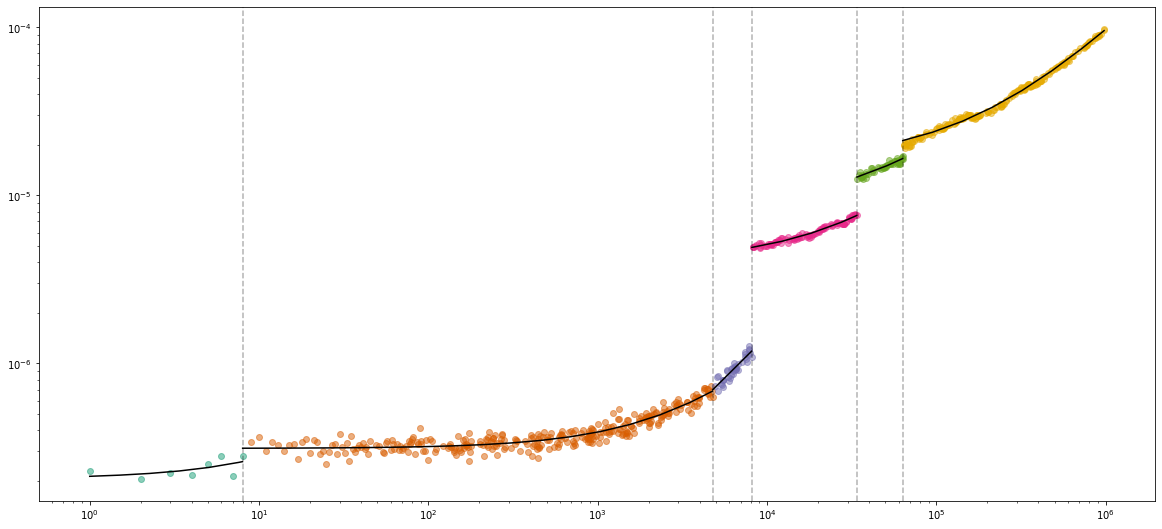

In [11]:
df_agg = aggregate_dataframe(df_send)
reg_send = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_send)
reg_send.plot_dataset(log=True)

In [12]:
reg_send.to_pandas()

min_x    max_x     intercept   coefficient           RSS           MSE  \
0     -inf      8.0  2.064276e-07  6.785879e-09  3.984167e-15  4.980209e-16   
1      8.0   4778.0  3.126291e-07  7.794590e-11  3.118971e-13  9.901496e-16   
2   4778.0   8133.0  7.346840e-40  1.458088e-10  1.302755e-13  3.101798e-15   
3   8133.0  33956.0  4.052195e-06  1.042737e-10  1.840001e-12  1.786408e-14   
4  33956.0  63305.0  8.556209e-06  1.262608e-10  9.283729e-12  1.785332e-13   
5  63305.0      inf  1.603208e-05  8.109831e-11  2.459465e-10  1.205620e-12   

     RSSlog  weighted_RSS  statsmodels_intercept  statsmodels_coefficient  
0  0.068376  4.436866e-16           2.064663e-07             7.047881e-09  
1  2.053073  8.936655e-17           3.126459e-07             7.927045e-11  
2  0.148719  3.224656e-21          -3.338367e-08             1.512429e-10  
3  0.051036  7.126560e-21           4.052195e-06             1.044001e-10  
4  0.042916  4.239148e-21           8.556209e-06             1.263659e-10  
5  0.235232  1.240899e-20           1.603208e-05             8.107116e-11

In [13]:
regressions_send = SegmentedRegression()

for i, row in reg_send.to_pandas().iterrows():
    regressions_send.append(compute_mixture_regression(df_send, row), row["min_x"], row["max_x"])


Old coeff: 6.785879e-09


R[write to console]: Error in rq(formula = "duration ~ msg_size", data = df, tau = 0.05) : 
  could not find function "rq"




Error in rq(formula = "duration ~ msg_size", data = df, tau = 0.05) : 
  could not find function "rq"


RInterpreterError: Failed to parse and evaluate line "rq(formula='duration ~ msg_size', data=df, tau=0.05)".
R error message: 'Error in rq(formula = "duration ~ msg_size", data = df, tau = 0.05) : \n  could not find function "rq"'

## Verification: generating the send durations

In [ ]:
send_generated = pandas.DataFrame(dict(msg_size=df_send.sample(n=100000).msg_size))
send_generated['duration'] = send_generated.apply(lambda row: regressions_send.sample(row['msg_size']), axis=1)
send_generated.head()

In [ ]:
df_send['origin'] = 'real'
send_generated['origin'] = 'generated'
tmp = pandas.concat([send_generated, df_send.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated send durations')
plot

### Code extraction

In [ ]:
regressions_send

In [ ]:
regressions_send.pretty_c()

## MPI_Isend

In [ ]:
df_agg = aggregate_dataframe(df_isend)
reg_isend = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_isend)
reg_isend.plot_dataset(log=True)

In [ ]:
reg_isend.to_pandas()

In [ ]:
regressions_isend = SegmentedRegression()

for i, row in reg_isend.to_pandas().iterrows():
    regressions_isend.append(compute_mixture_regression(df_isend, row), row["min_x"], row["max_x"])


## Verification: generating the durations

In [ ]:
isend_generated = pandas.DataFrame(dict(msg_size=df_isend.sample(n=100000).msg_size))
isend_generated['duration'] = isend_generated.apply(lambda row: regressions_isend.sample(row['msg_size']), axis=1)
isend_generated.head()

In [ ]:
df_isend['origin'] = 'real'
isend_generated['origin'] = 'generated'
tmp = pandas.concat([isend_generated, df_isend.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated isend durations')
plot

In [ ]:
df_isend['origin'] = 'real'
isend_generated['origin'] = 'generated'
tmp = pandas.concat([isend_generated, df_isend.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + ggtitle('Comparison of real and generated isend durations')
plot

### Code extraction

In [ ]:
regressions_isend

In [ ]:
regressions_isend.pretty_c()

## MPI_Recv

In [ ]:
df_agg = aggregate_dataframe(df_recv)
reg_recv = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_recv)
reg_recv.plot_dataset(log=True)

In [ ]:
reg_recv.to_pandas()

In [ ]:
regressions_recv = SegmentedRegression()

for i, row in reg_recv.to_pandas().iterrows():
    regressions_recv.append(compute_mixture_regression(df_recv, row), row["min_x"], row["max_x"])


## Verification: generating the durations

In [ ]:
recv_generated = pandas.DataFrame(dict(msg_size=df_recv.sample(n=100000).msg_size))
recv_generated['duration'] = recv_generated.apply(lambda row: regressions_recv.sample(row['msg_size']), axis=1)
recv_generated.head()

In [ ]:
df_recv['origin'] = 'real'
recv_generated['origin'] = 'generated'
tmp = pandas.concat([recv_generated, df_recv.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated recv durations')
plot

In [ ]:
df_recv['origin'] = 'real'
recv_generated['origin'] = 'generated'
tmp = pandas.concat([recv_generated, df_recv.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + ggtitle('Comparison of real and generated recv durations')
plot

### Code extraction

In [ ]:
regressions_recv

In [ ]:
regressions_recv.pretty_c()

## MPI_PingPong

In [ ]:
df_agg = aggregate_dataframe(df_pingpong)
reg_pingpong = compute_regression(df_agg['msg_size'], df_agg['duration'], mode='log')
print(reg_pingpong)
reg_pingpong.plot_dataset(log=True)

In [ ]:
reg_pingpong.to_pandas()

In [ ]:
regressions_pingpong = SegmentedRegression()

for i, row in reg_pingpong.to_pandas().iterrows():
    regressions_pingpong.append(compute_mixture_regression(df_pingpong, row), row["min_x"], row["max_x"])


## Verification: generating the durations

In [ ]:
pingpong_generated = pandas.DataFrame(dict(msg_size=df_pingpong.sample(n=100000).msg_size))
pingpong_generated['duration'] = pingpong_generated.apply(lambda row: regressions_pingpong.sample(row['msg_size']), axis=1)
pingpong_generated.head()

In [ ]:
df_pingpong['origin'] = 'real'
pingpong_generated['origin'] = 'generated'
tmp = pandas.concat([pingpong_generated, df_pingpong.sample(n=100000)])
plot = ggplot(tmp, aes(x='msg_size', y='duration', color='origin')) + geom_point(alpha=0.1)
plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + ggtitle('Comparison of real and generated ping-pong durations')
plot

### Code extraction

In [ ]:
regressions_pingpong

In [ ]:
async_model = SegmentedRegression()

all_intercepts = []
for mode in regressions_pingpong.segments[-1][0].intercept.modes:
    all_intercepts.append((mode[0]/2, mode[1]))

print(regressions_pingpong.segments[-1][0].coefficient)
async_model.append(LinearRegression(
        intercept = Mixture(*all_intercepts),
        coefficient = regressions_pingpong.segments[-1][0].coefficient
    ), regressions_pingpong.segments[-1][1], regressions_pingpong.segments[-1][2]
)

async_model

In [ ]:
async_model.pretty_c()

In [ ]:
regressions_pingpong/2